In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import UpSampling2D

In [2]:
physical_device = tf.config.list_physical_devices("GPU")
# tf.config.gpu.set_per_process_memory_fraction(0.5)
try:
    tf.config.experimental.set_memory_growth(
        physical_device[0], True
    )
except Exception as e:
    print(e)
    


In [3]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# # sess config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.4


In [4]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [5]:
physical_device = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(
        physical_device[0], True
    )
except Exception as e:
    print(e)
    
print(len(physical_device)) 

1


In [6]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [7]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters =F1, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters =F2, kernel_size =(f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters =F3, kernel_size =(1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters =F3, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [8]:

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 1)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 1)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
   
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [9]:
model = ResNet50(input_shape = (240, 320, 3))

In [10]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 160, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 160, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
# loading resnet50 model using tensorflow
model2=tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(240,320,3), pooling=None, 
)

In [12]:
model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 160, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
print(model2.output_shape)

(None, 8, 10, 2048)


In [14]:
for i in range(1,len(model.layers)):
#     print(i, model.layers[i].output_shape, model2.layers[i].output_shape)
#     print(model.layers[i],model2.layers[i])
    try:
        weights = model2.layers[i].get_weights()
        model.layers[i].set_weights(weights)
        print(i)
    except Exception as e:
        print("pass",i)
        pass

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
pass 45
pass 46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
pass 87
pass 88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
pass 149
pass 150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


In [15]:
def depth_model(model_output):

    '''
      make depth model after resnet50 model( feature extractor ) 
        1. increasing size(double) of previous layer output using bilinear upsampling 2d layer 
        2. adding convolution layer after upsamling layer
        3. repeat step 2nd and step 3rd 4 times 
    ''' 
    x1_depth = tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation='bilinear',name='upsampling1')(model_output)
    f1_depth = tf.keras.layers.Conv2D(512,(1,1),padding='same',name='conv1_d',activation='relu')(x1_depth)
    f1_depth = tf.keras.layers.BatchNormalization()(f1_depth) 
    
    
    x2_depth=tf.keras.layers.UpSampling2D(size= (2,2),data_format=None,interpolation='bilinear',name='upsampling2')(f1_depth)
    f2_depth=tf.keras.layers.Conv2D(128,(1,1),padding='same',name='conv2_d',activation='relu')(x2_depth)
    f2_depth = tf.keras.layers.BatchNormalization()(f2_depth) 
    
    x3_depth=tf.keras.layers.UpSampling2D(size=(2,2),data_format=None,interpolation='bilinear',name='upsampling3')(f2_depth)
    f3_depth=tf.keras.layers.Conv2D(64,(1,1),padding='same',name='conv3_d',activation='relu')(x3_depth)
    f3_depth = tf.keras.layers.BatchNormalization()(f3_depth) 
    
    
    
    
    x4_depth=tf.keras.layers.UpSampling2D(size= (2,2), data_format=None, interpolation='bilinear',name='upsampling4')(f3_depth)
    f4_depth=tf.keras.layers.Conv2D(1,(1,1),padding='same',name="conv4_d",activation='relu')(x4_depth)
    f4_depth = tf.keras.layers.BatchNormalization()(f4_depth) 
    


    '''
      Apply semi dense up skip connection between f_in, f1, f2, f3 layer
      f_out=h(f_in)+sumation_of_(h(f(i))) where i belong to (1,n)
    '''
    #add_shape  of f4 output
    f4_depth_shape_x_y = (240,320)
    f4_depth_filters=f4_depth.shape[3]

    # BASE INPUT LAYER UPSAMPLING
    bilinear_upsampling_in = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(model_output)
    f_depth_out_in=tf.keras.layers.Conv2DTranspose(f4_depth_filters,(1,1),name='resize_filter_conv_in',activation='relu')(bilinear_upsampling_in)

    # FIRST LAYER BILINEAR UPsAMPLING
    bilinear_upsampling_1 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f1_depth)
    f_depth_out1 = tf.keras.layers.Conv2DTranspose(f4_depth_filters,(1,1),name='resize_filter_conv1',activation='relu')(bilinear_upsampling_1)

    #SECOND LAYER BILINEAR UPSAMPLING
    bilinear_upsampling_2 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f2_depth)
    f_depth_out2 = tf.keras.layers.Conv2DTranspose(f4_depth_filters,(1,1),name='resize_filter_conv2',activation='relu')(bilinear_upsampling_2)

    # 3rd LAYER UPSAMPLING
    bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f3_depth)
    f_depth_out3 = tf.keras.layers.Conv2DTranspose(f4_depth_filters,(1,1),name='resize_filter_conv3',activation='relu')(bilinear_upsampling_3)
    
    # bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4.shape[1], f4.shape[2], interpolation='bilinear')(f3)
    # f_out3 = tf.keras.layers.Conv2D(f4_filters,(1,1),name='resize_filter_conv3')(bilinear_upsampling_3)

    #F_out LAYER UPSAMPLING
    bilinear_upsampling_4 = tf.keras.layers.experimental.preprocessing.Resizing(f4_depth_shape_x_y[0], f4_depth_shape_x_y[1], interpolation='bilinear')(f4_depth)
    f_depth_out4 = tf.keras.layers.Conv2DTranspose(f4_depth_filters,(1,1),name='resize_filter_conv4',activation='relu')(bilinear_upsampling_4)

    
    ''' Applying formulae for semi dense up skip connection '''
    f_depth_out=tf.keras.layers.Add()([f_depth_out_in,f_depth_out1,f_depth_out2,f_depth_out3,f_depth_out4])
    f_final = tf.keras.layers.Conv2D(1,(1,1),name='final_depth',activation = 'relu')(f_depth_out)
    
    
    
    # put the code below out of this function
    ''' Building depth model from Vgg16 to f_out'''
    from tensorflow.keras import Model    
    depth_model=Model(inputs=model.input,outputs=f_final)
    depth_model.summary()
    return depth_model




In [16]:
"""def semantic_model(model_output):

    '''
      make semantic model after resnet50 model( feature extractor ) 
        1. increasing size(double) of previous layer output using bilinear upsampling 2d layer 
        2. adding convolution layer after upsamling layer
        3. repeat step 2nd and step 3rd 4 times 
    ''' 
    x1_semantic=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation='bilinear',name='upsampling1')(model_output)
    f1_semantic=tf.keras.layers.Conv2D(64,(1,1),padding='same',name='conv1')(x1_semantic)

    x2_semantic=tf.keras.layers.UpSampling2D(size= (2,2),data_format=None,interpolation='bilinear',name='upsampling2')(f1_semantic)
    f2_semantic=tf.keras.layers.Conv2D(32,(1,1),padding='same',name='conv2')(x2_semantic)

    x3_semantic=tf.keras.layers.UpSampling2D(size=(2,2),data_format=None,interpolation='bilinear',name='upsampling3')(f2_semantic)
    f3_semantic=tf.keras.layers.Conv2D(16,(1,1),padding='same',name='conv3')(x3_semantic)

    x4_semantic=tf.keras.layers.UpSampling2D(size= (2,2), data_format=None, interpolation='bilinear',name='upsampling4')(f3_semantic)
    f4_semantic=tf.keras.layers.Conv2D(3,(1,1),padding='same',name="conv4")(x4_semantic)
    
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
#     print("output)
    '''
      Apply semi dense up skip connection between f_in, f1, f2, f3 layer
      f_out=h(f_in)+summation_of_(h(f(i))) where i belong to (1,n)
    '''
    #add_shape  of f4 output
    f4_semantic_shape_x_y = (240,320)
    f4_semantic_filters=f4_semantic.shape[3]
    
    # BASE INPUT LAYER UPSAMPLING
    bilinear_upsampling_in = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(model_output)
    f_semantic_out_in=tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv_in',activation='relu')(bilinear_upsampling_in)

    # FIRST LAYER BILINEAR UPsAMPLING
    bilinear_upsampling_1 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f1_semantic)
    f_semantic_out1 =tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv1',activation='relu')(bilinear_upsampling_1)

    #SECOND LAYER BILINEAR UPSAMPLING
    bilinear_upsampling_2 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f2_semantic)
    f_semantic_out2 = tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv2',activation='relu')(bilinear_upsampling_2)

    # 3rd LAYER UPSAMPLING
    bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f3_semantic)
    f_semantic_out3 = tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv3',activation='relu')(bilinear_upsampling_3)
    # bilinear_upsampling_3 = tf.keras.layers.experimental.preprocessing.Resizing(f4.shape[1], f4.shape[2], interpolation='bilinear')(f3)
    # f_out3 = tf.keras.layers.Conv2D(f4_filters,(1,1),name='resize_filter_conv3')(bilinear_upsampling_3)

    #F_out LAYER UPSAMPLING
    bilinear_upsampling_4 = tf.keras.layers.experimental.preprocessing.Resizing(f4_semantic_shape_x_y[0], f4_semantic_shape_x_y[1], interpolation='bilinear')(f4_semantic)
    f_semantic_out4 = tf.keras.layers.Conv2DTranspose(f4_semantic_filters,(1,1),name='resize_filter_conv4',activation='relu')(bilinear_upsampling_4)

    
    ''' Applying formulae for semi dense up skip connection '''
#     f_semantic_out = f_semantic_out_in + f_semantic_out1 + f_semantic_out2 + f_semantic_out3 + f_semantic_out4
    f_depth_out=tf.keras.layers.Add()([f_semantic_out_in,f_semantic_out1,f_semantic_out2,f_semantic_out3,f_semantic_out4])



    ''' Building semantic model from Vgg16 to f_out'''
    from tensorflow.keras import Model
    semantic_model=Model(inputs=model.input,outputs=f_semantic_out)
    semantic_model.summary()
    return semantic_model
"""



'def semantic_model(model_output):\n\n    \'\'\'\n      make semantic model after resnet50 model( feature extractor ) \n        1. increasing size(double) of previous layer output using bilinear upsampling 2d layer \n        2. adding convolution layer after upsamling layer\n        3. repeat step 2nd and step 3rd 4 times \n    \'\'\' \n    x1_semantic=tf.keras.layers.UpSampling2D(size=(2,2) , data_format=None, interpolation=\'bilinear\',name=\'upsampling1\')(model_output)\n    f1_semantic=tf.keras.layers.Conv2D(64,(1,1),padding=\'same\',name=\'conv1\')(x1_semantic)\n\n    x2_semantic=tf.keras.layers.UpSampling2D(size= (2,2),data_format=None,interpolation=\'bilinear\',name=\'upsampling2\')(f1_semantic)\n    f2_semantic=tf.keras.layers.Conv2D(32,(1,1),padding=\'same\',name=\'conv2\')(x2_semantic)\n\n    x3_semantic=tf.keras.layers.UpSampling2D(size=(2,2),data_format=None,interpolation=\'bilinear\',name=\'upsampling3\')(f2_semantic)\n    f3_semantic=tf.keras.layers.Conv2D(16,(1,1),paddin

In [17]:
depth_model= depth_model(model.output)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 160, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 160, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(depth_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [19]:
# import pandas as pd
# df=pd.read_csv("nyu_data/data/nyu2_train.csv")
# data=df.values
# print(data.shape)
# x_train = []
# y_train = []
# count=0
# path = "nyu_data"
# for i in range(data.shape[0]):
# #     print(data[i][0])
#     try:
#         x = cv2.imread(os.path.join(path,data[i][0]))
#         x = cv2.resize(x,(320,240))
#     #     print(data[i][1])
#         y = cv2.imread(os.path.join(path,data[i][1]))
#         y = cv2.resize(y,(320,240))
#         y = cv2.cvtColor(y,cv2.COLOR_BGR2GRAY)   
  
#         x_train.append(x)
#         y_train.append(y)
#     except Exception as e:
#         print(e)
#     count+=1
#     if(count%10000==0):
#         print(count)
# #     if(count>1000):
# #         break

# x_train = np.array(x_train)
# y_train = np.array(y_train)


In [20]:
# import pandas as pd
# import cv2
# import os
# import numpy as np
# df = pd.read_csv("nyu_data/data/nyu2_train.csv")
# data = df.values
# xdata = data[:,0]
# ydata = data[:,1]
# def LoadBatch(xdata,ydata,batch_size):
#     x_train = []
#     y_train = []
#     Pointer = 0
#     l = len(xdata)
#     path="nyu_data"
#     while True:
#         try:
#             print(os.path.join(path,xdata[(Pointer)%l]))
#             x = cv2.imread(os.path.join(path,xdata[(Pointer)%l]))
#             x = cv2.resize(x,(320,240))/255.0
#             y=cv2.imread(os.path.join(path,ydata[(Pointer)%l]))
#             y=cv2.resize(y, (320,240))
#             y = cv2.cvtColor(y,cv2.COLOR_BGR2GRAY)
#             x_train.append(x)
#             y_train.append(y)
#             Pointer = Pointer+1
#             print(e)
#         except Exception as e:
#             print(e)
#             pass
#         if len(x_train)==batch_size:
#             print("done")
#             yield np.array(x_train),np.array(y_train)
#             x_train = []
#             y_train = []

In [21]:
# batch_size = 2
# train_data_generator = LoadBatch(xdata,ydata,batch_size)
# # valid_data_generator = LoadBatch(xdata,ydata,batch_size)
# train_data_generator= next(LoadBatch(xdata,ydata,batch_size))


In [22]:
# while(True):
#     train_data_generator= next(LoadBatch(xdata,ydata,batch_size)) 

In [23]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import os
import json


class DataGenerator(Sequence):
    def __init__(self, x_data, y_data,
                 batch_size=32, dim=(320,240),
                 shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.dim = dim


    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))


    def __getitem__(self, index):
        start_index = index * self.batch_size
        x_train = []
        y_train = []
        i = start_index - 1
        while len(x_train) < self.batch_size:
            try:
              
                img = cv2.imread(self.x_data[i % len(self.x_data)])
                img = cv2.resize(img,(320,240))
                img = np.array(img, dtype = np.float32)
                y_img=cv2.imread(self.y_data[i%len(self.y_data)])
                y_img=cv2.resize(y_img, (320,240))
                y_img=np.array(y_img, dtype = np.float32)
                y_img = cv2.cvtColor(y_img,cv2.COLOR_BGR2GRAY)
                x_train.append(img)
                y_train.append(y_img)
                i += 1

            except Exception as err:
                print(err)
                continue
            
        x_train = np.array(x_train)
        y_train = np.array(y_train)
    # dtype=np.float32) / 255
        return x_train, y_train



In [24]:
import os 
import numpy as np
xdata = []
ydata = []
path= "nyu_data/data/nyu2_train"
for  folder in os.listdir(path):
    folder_path=os.path.join(path,folder)
    for img_name in os.listdir(folder_path):
        if(img_name[-4:]=='.jpg'):
            x_name=path+'/'+folder+'/'+img_name
            y_name=x_name[:-4]+'.png'
            xdata.append(x_name)
            ydata.append(y_name)
xdata=np.array(xdata)
ydata=np.array(ydata)

In [25]:
# import os 
# import numpy as np
# xdata = []
# ydata = []
# path= "nyu_data/data/nyu2_train"
# for i in os.listdir(path):
#     for j in os.listdir(path + '/' + i):
#         if(j[-4:]=='.jpg'):
#             xdata.append(path + '/' + i + '/' + j)
#         if j[-4:] == '.png':
#             ydata.append(path + '/' + i + '/' + j)
# xdata=np.array(xdata)
# ydata=np.array(ydata)

In [26]:
print(len(xdata))

7332


In [27]:
train_data = DataGenerator(xdata, ydata, batch_size=2,dim=(320,240))

In [28]:
import random

In [29]:
a = train_data.__getitem__(random.randint(0, 20000))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


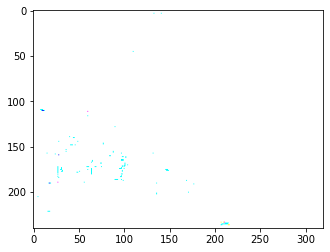

In [30]:
import matplotlib.pyplot as plt
plt.imshow(a[0][0])
# cv2.imshow("frame",a[0][0])
plt.show()

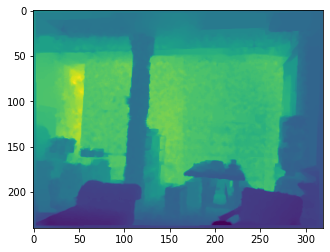

In [31]:
plt.imshow(a[1][0])
plt.show()

In [32]:
def smooth_l1_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.keras.losses.huber(y_true, y_pred))
    return loss

In [33]:
def depth_aware_loss(y_true, y_pred):
    #converting images to tensor
#     y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)

#     y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    y_true = tf.conver_to_tensor(y_true,dtype=tf.float32)
    y_pred = tf.conver_to_tensor(y_pred, dtype= tf.float32)
    i = tf.image.convert_image_dtype(y_true, dtypoe = tf.float32)
    #lamba d :
    lambda_d = 1 - ((tf.math.minimum(tf.math.log(y_pred), tf.math.log(y_true))) / (tf.math.maximum(tf.math.log(y_pred), tf.math.log(y_true))))
#     print(" alpha_d:  ",alpha_d.shape)

#     print("lambda_d_shape:  ",lambda_d.shape)
#     print("tf.math.abs(y_true - y_pred))_shape ",(tf.math.abs(y_true - y_pred)).shape)
#     print("((y_true/255.0) + lambda_d)_shape ",((y_true/255.0) + lambda_d).shape)
#     coef = tf.convert_to_tensor(((y_true/255.0) + lambda_d), dtype = tf.float32)
    loss1 = tf.reduce_mean((i + lambda_d) * tf.math.abs(y_true - y_pred))
#     print("loss:   ",loss)
#     print("((y_true/255.0) + lambda_d) * tf.math.abs(y_true - y_pred)_shape",(((y_true/255.0) + lambda_d) * tf.math.abs(y_true - y_pred)).shape)
#     print("loss_shape:    ",loss.shape)
#     smooth_l1 = smooth_l1_loss(y_true, y_pred)
#     loss = loss1 + smooth_l1
    return loss1

In [34]:
def depth_gradient_loss(y_true, y_pred):
#     print("in depth_gradient losss")
#     print(y_pred.shape)
    # y_pred=y_pred[0]
#     print(y_pred.shape)
    y_true = tf.image.convert_image_dtype(y_true, dtype=tf.float32)
    y_true = tf.expand_dims(y_true, axis = 3)
    y_pred = tf.image.convert_image_dtype(y_pred, dtype = tf.float32)
    y_pred = tf.expand_dims(y_pred, axis = 3)
    #y_true edges

    sobel_true = tf.image.sobel_edges(y_true)
    sobel_true_h = sobel_true[0, :, :, :, 0]
    sobel_true_w = sobel_true[0, :, :, :, 1]
    #y_pred edges
    sobel_pred = tf.image.sobel_edges(y_pred)
    sobel_pred_h = sobel_pred[0, :, :, :, 0]
    sobel_pred_w = sobel_pred[0, :, :, :, 1]
    #loss
    # y_true = tf.squeeze(y_true, axis = 0)
    # t_pred = tf.squeeze(y_pred, axis = 0)
    loss_depth = tf.reduce_mean(tf.math.abs(sobel_pred_h - sobel_true_h) + tf.math.abs(sobel_pred_w - sobel_true_w))
#     N = y_true.shape[1]
#     loss_depth = loss_depth/(N * N)
    return loss_depth

In [35]:
def combined_depth_loss(y_true,y_pred):
    
    loss1=depth_aware_loss(y_true,y_pred)
    loss2 = depth_gradient_loss(y_true,y_pred)
    loss=loss1+loss2
    return loss


In [36]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.0001)

In [37]:
depth_model.compile(optimizer=optimizer,loss=depth_aware_loss)

In [38]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    TensorBoard
)

In [39]:
# depth_model.load_weights("./checkpoints2/train_2.tf")


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f8318580c50> and <tensorflow.python.keras.layers.convolutional.UpSampling2D object at 0x7f831859ea50>).


ValueError: Shapes (512,) and (64,) are incompatible

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("checkpoints2/train_{epoch}.tf", verbose = 1,
                                                save_weights_only=True), 
             TensorBoard("logs")]

In [ ]:
depth_model.fit(train_data,epochs=50, callbacks = callbacks,verbose=1)

In [ ]:
depth_model.fit(train_data,epochs=10, callbacks = callbacks,verbose=1)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("checkpoints2/train_{epoch}.tf", verbose = 1,
                                                save_weights_only=True), 
             TensorBoard("logs")]

In [ ]:
depth_model.fit(train_data,epochs=30, callbacks = callbacks,verbose=1)

In [ ]:
depth_model.load_weights("./checkpoints/train_10.tf")

In [ ]:
import pandas as pd
df = pd.read_csv("nyu_data/data/nyu2_train.csv")
data = df.values
xdata = data[:,0]
ydata = data[:,1]
def LoadBatch(xdata,ydata,batch_size):
    x_train = []
    y_train = []
    Pointer = 0
    l = len(xdata)
    path="nyu_data"
    while True:
        try:
            x = cv2.imread(os.path.join(path,xdata[(Pointer)%l]))
            x = cv2.resize(x,(320,240))/255.0
            y=cv2.imread(os.path.join(path,ydata[(pointer)%l]))
            y=cv2.resize(y, (320,240))
            y = cv2.cvtColor(y,cv2.COLOR_BGR2GRAY)
            x_train.append(x)
            y_train.append(y)
            Pointer = Pointer+1
        except:
            pass
        if len(xd)==batch_size:
            yield np.array(xd),np.array(yd)
            xd = []
            yd = []

In [ ]:
import pandas as pd
df=pd.read_csv("nyu_data/data/nyu2_train.csv")
data=df.values
print(data.shape)
x_test = []
y_test = []
count=0
path = "nyu_data"
aaya=True
for i in range(data.shape[0]):
    if(i<1000):
        continue
#     print(data[i][0])
    try:
        x = cv2.imread(os.path.join(path,data[i][0]))
        x = cv2.resize(x,(320,240))
        y = cv2.imread(os.path.join(path,data[i][1]))
        print(data[i][1])
#         plt.imshow(data[i][1])
        y=cv2.resize(x,(320,240))
        y = cv2.cvtColor(y,cv2.COLOR_BGR2GRAY)
        x_test.append(x)
        y_test.append(y)
        if(aaya):
            break
    except Exception as e:
        print(e)

x_test =  np.array(x_test)
y_test = np.array(y_test)


In [ ]:
print(data[0][0])
print(data[0][1])
x_test = []
y_test = []
x = cv2.imread(os.path.join(path,data[0][0]))
x = cv2.resize(x,(320,240))
y = cv2.imread(os.path.join(path,data[0][1]))
print(data[i][1])
#         plt.imshow(data[i][1])
y=cv2.resize(y,(320,240))
y = cv2.cvtColor(y,cv2.COLOR_BGR2GRAY)
x_test.append(x)
y_test.append(y)

x_test =  np.array(x_test)
y_test = np.array(y_test)


In [ ]:
img=depth_model.predict(x_test)

In [ ]:
plt.imshow(x_test[0])
plt.show()

In [ ]:
# print(img)
print(img[0].shape)
import matplotlib.pyplot as plt
plt.imshow(img[0]*255,cmap='gray')
plt.show()

In [ ]:
plt.imshow(y_test[0],cmap='gray')

In [ ]:
import pandas as pd
df=pd.read_csv("nyu_data/data/nyu2_train.csv")
data=df.values
print(data.shape)
# x_train = []
y2_train = []
count=0
path = "nyu_data"
for i in range(data.shape[0]):
    count+=1
    if(i<10):
        continue
    print(i)
#     print(data[i][0])
#     x = cv2.imread(os.path.join(path,data[i][0]))
#     x = cv2.resize(x,(320,240))
#     print(data[i][1])
    y = cv2.imread(os.path.join(path,data[i][1]))
    y = cv2.resize(y,(320,240))
    y = cv2.cvtColor(y,cv2.COLOR_BGR2GRAY)   
  
#     x_train.append(x)
    y2_train.append(y)
    
    if(count%10==0):
        print(count)
    if(count>20):
        break

x_train = np.array(x_train)
y_train = np.array(y_train)
